<a href="https://colab.research.google.com/github/visha1Sagar/Practice/blob/main/yolo_blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.pt").to('cuda', dtype=torch.float32)
model.fuse = False  # Disable layer fusion

In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3ihm4yqJ5ShsXw7WY3uI")
project = rf.workspace("icrl-lab").project("human-segmentation-from-crowd")
version = project.version(5)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.9 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-segmentation-from-crowd-5 in yolov11:: 100%|██████████| 978/978 [00:02<00:00, 383.21it/s]


In [ ]:
import cv2
import numpy as np

def adjust_brightness_contrast(image):
    # Analyze brightness distribution using histogram
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Compute average brightness
    avg_brightness = np.sum(hist * np.arange(256)) / np.sum(hist)
    gamma = max(0.3, 1 - avg_brightness / 255)  # Adaptive gamma based on brightness

    # Gamma correction
    inv_gamma = 0.8 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def add_color_cast(image):
    # Analyze color distribution
    b, g, r = cv2.split(image)
    avg_b = np.mean(b)
    avg_r = np.mean(r)

    # Adaptive intensity based on average channel values
    blue_intensity = 1.25 if avg_b < 100 else 1.1
    red_intensity = 1.25 if avg_r < 100 else 1.1

    b = np.clip(b * blue_intensity, 0, 255).astype("uint8")
    r = np.clip(r * red_intensity, 0, 255).astype("uint8")
    return cv2.merge([b, g, r])

def add_noise(image):
    # Analyze noise level based on image brightness
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    avg_brightness = np.mean(gray)
    noise_level = 0.1 if avg_brightness > 100 else 0.15  # More noise for darker images

    row, col, ch = image.shape
    mean = 0
    sigma = noise_level * 255
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss
    return np.clip(noisy_image, 0, 255).astype("uint8")

def add_motion_blur(image):
    # Randomize blur angle and kernel size
    kernel_size = np.random.randint(10, 15)  # Adaptive kernel size
    angle = np.random.randint(0, 360)        # Random motion direction

    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1.0), (kernel_size, kernel_size))
    kernel /= np.sum(kernel)
    return cv2.filter2D(image, -1, kernel)

def add_light_source(image):
    # Randomize light source position and intensity
    height, width = image.shape[:2]
    center = (np.random.randint(0, width), np.random.randint(0, height))
    radius = np.random.randint(80, 150)  # Adaptive radius
    intensity = np.random.uniform(1.5, 2.5)  # Adaptive intensity

    mask = np.zeros_like(image)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    mask = mask.astype(np.float32) / 255.0
    return np.clip(image + mask * intensity, 0, 255).astype("uint8")

def post_process(image):
    # Edge-preserving smoothing
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def simulate_low_light(image):
    # Step 1: Adjust brightness and contrast
    image = adjust_brightness_contrast(image)

    # Step 2: Add color cast (blue/red lights)
    image = add_color_cast(image)

    # Step 3: Add noise
    image = add_noise(image)

    # Step 4: Add motion blur
    image = add_motion_blur(image)

    # Step 5: Add light source
    image = add_light_source(image)

    # Step 6: Post-process
    image = post_process(image)

    return image



In [ ]:
import os
import cv2

# Assuming 'train/images' is the directory containing your images
image_dir = "/content/Human-segmentation-from-crowd-5/valid/images"

for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust extensions if needed
        filepath = os.path.join(image_dir, filename)
        try:
            # Load the image
            image = cv2.imread(filepath)
            if image is None:
                print(f"Could not load image: {filepath}")
                continue

            # Simulate low-light conditions
            low_light_image = simulate_low_light(image)

            # Save the transformed image with the same name
            cv2.imwrite(filepath, low_light_image)
            print(f"Processed and saved: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

Processed and saved: 7_mp4-184_jpg.rf.ff776f5672eb7982bd1c630721a9c043.jpg
Processed and saved: 2_mp4-22_jpg.rf.2a9959e5dc8d8ce2649150a7e86fddc7.jpg
Processed and saved: 4_mp4-60_jpg.rf.25983229a0fab8bdd7c57a6de85c9d77.jpg
Processed and saved: 4_mp4-21_jpg.rf.49968b9c248ce90339aedc4bf7fe1a90.jpg
Processed and saved: 1_mp4-33_jpg.rf.927f9a788d765e5067251fda7ede76fc.jpg
Processed and saved: 7_mp4-55_jpg.rf.b1c4e1abef11d8fe759ed718b0a2a6b0.jpg
Processed and saved: 1_mp4-0_jpg.rf.78737f2ab6aef4c6549007c5f30fc044.jpg
Processed and saved: 1_mp4-66_jpg.rf.d7f8df6cd67342bed3cf78c6b71e157b.jpg
Processed and saved: 7_mp4-29_jpg.rf.397f58d7c02f97e38eb8c16726f4b531.jpg
Processed and saved: 7_mp4-135_jpg.rf.f8925cb7039e54b8785dbedfe3e928b8.jpg
Processed and saved: 7_mp4-46_jpg.rf.6cd9085d20cc804dc8f2a186fbd6571f.jpg
Processed and saved: 4_mp4-32_jpg.rf.799128a4e66734a3257b4986c7f825e5.jpg
Processed and saved: 7_mp4-167_jpg.rf.4281efe709dea1eba823fc5b1b1c6c0b.jpg
Processed and saved: 7_mp4-88_jpg.rf

In [ ]:
import os

# Create the datasets folder if it doesn't exist
datasets_folder = "datasets"
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)

# Move the folder
!mv Human-segmentation-from-crowd-5 datasets

In [ ]:
results = model.train(data="/content/datasets/Human-segmentation-from-crowd-5/data.yaml", epochs=20, imgsz=640)

engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/datasets/Human-segmentation-from-crowd-5/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscrip

train: Scanning /content/datasets/Human-segmentation-from-crowd-5/train/labels.cache... 338 images, 2 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/Human-segmentation-from-crowd-5/valid/labels.cache... 96 images, 1 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.84G       1.86      3.636      2.801      1.439         37        640: 100%|██████████| 22/22 [00:25<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         96        728     0.0226      0.893      0.297      0.144     0.0208      0.821      0.254      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.57G      1.507      2.736      1.838      1.211         20        640: 100%|██████████| 22/22 [00:20<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all         96        728      0.694      0.264      0.385      0.217      0.694      0.264      0.363      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.71G      1.468      2.693       1.51       1.22         49        640: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         96        728       0.58      0.324      0.401      0.218      0.545      0.289      0.349       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.83G      1.392       2.63      1.447      1.185         31        640: 100%|██████████| 22/22 [00:20<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all         96        728      0.499      0.402      0.392      0.199      0.491       0.39      0.366      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.58G        1.4      2.572      1.423      1.198         17        640: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

                   all         96        728      0.616      0.522      0.547      0.332      0.608      0.507      0.532       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.78G      1.335      2.493      1.362      1.169         31        640: 100%|██████████| 22/22 [00:19<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         96        728      0.474      0.512       0.49      0.298      0.469      0.473      0.457      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.71G      1.332      2.508      1.306       1.15         46        640: 100%|██████████| 22/22 [00:19<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all         96        728      0.588      0.593      0.601      0.372      0.565      0.577      0.571      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.67G      1.264      2.327      1.248       1.13         34        640: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]

                   all         96        728      0.645      0.654      0.665      0.432      0.642      0.641       0.64      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.71G      1.261      2.364      1.238      1.121         23        640: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         96        728      0.631      0.626      0.639      0.427      0.626       0.62      0.616      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.63G      1.241      2.319      1.255      1.112         10        640: 100%|██████████| 22/22 [00:19<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


                   all         96        728      0.698      0.659      0.703      0.485      0.694      0.652      0.691      0.431
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.26G      1.215      2.273       1.34      1.105         13        640: 100%|██████████| 22/22 [00:19<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all         96        728      0.652      0.637      0.675      0.482      0.641      0.629      0.654      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.25G      1.151      2.194      1.226      1.077         13        640: 100%|██████████| 22/22 [00:13<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all         96        728      0.685       0.67      0.701      0.471      0.683      0.663      0.684      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.27G      1.102       2.06      1.173      1.051         15        640: 100%|██████████| 22/22 [00:12<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

                   all         96        728      0.678      0.726      0.727      0.527      0.676      0.722      0.721      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.29G      1.088       2.07      1.159      1.051          9        640: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

                   all         96        728      0.708      0.713      0.731      0.537      0.701      0.721      0.727      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.28G      1.052      1.987      1.112      1.038         11        640: 100%|██████████| 22/22 [00:10<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

                   all         96        728      0.729      0.724      0.752      0.534      0.724      0.714      0.739      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.27G      1.035      1.979      1.061      1.026         19        640: 100%|██████████| 22/22 [00:11<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all         96        728      0.723      0.721      0.749      0.549      0.715       0.72      0.739        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.25G       1.01      1.917      1.063      1.014         19        640: 100%|██████████| 22/22 [00:10<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

                   all         96        728      0.709      0.739      0.745      0.548      0.711      0.732      0.739      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.21G     0.9968      1.877      1.035      1.025         22        640: 100%|██████████| 22/22 [00:11<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all         96        728      0.734      0.736      0.764      0.575      0.737      0.738      0.759      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.34G     0.9654      1.818      1.015     0.9892          9        640: 100%|██████████| 22/22 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         96        728      0.723       0.76       0.77      0.581      0.742      0.743      0.764      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.22G      0.946      1.797      1.026     0.9765          5        640: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         96        728      0.723      0.747      0.775      0.586      0.728      0.735      0.768      0.522



20 epochs completed in 0.128 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 6.0MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


                   all         96        728      0.725      0.747      0.776      0.585      0.728      0.735      0.768      0.523
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train4


In [ ]:
results = model("/content/trial.png")


image 1/1 /content/trial.png: 384x640 1 Human, 38.7ms
Speed: 3.6ms preprocess, 38.7ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40'}
 obb: None
 orig_img: array([[[ 96, 159, 157],
         [ 95, 158, 156],
         [ 92, 157, 155],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 99, 162, 160],
         [ 95, 160, 158],
         [ 92, 157, 155],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 97, 162, 160],
         [ 93, 160, 157],
       

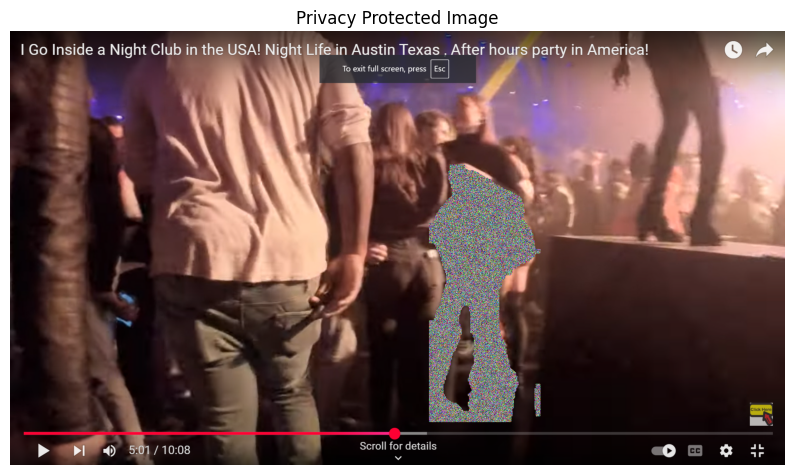

In [ ]:
# Extract the original image and masks
original_image = results[0].orig_img  # Original image as a NumPy array
masks = results[0].masks  # Mask data

if masks is not None:
    # Create a copy of the original image to apply noise
    protected_image = original_image.copy()
    masks_data = masks.data.cpu().numpy()  # Convert to NumPy

    for mask in masks_data:
        # Resize mask to original image dimensions
        mask_resized = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))

        # Create binary mask where the mask is above threshold
        mask_binary = mask_resized > 0.5

        # Generate Gaussian noise with the same shape as the image
        # Using mean=128 and std=100 for stronger noise (adjust std as needed)
        noise = np.random.normal(loc=128, scale=100, size=original_image.shape)
        noise = np.clip(noise, 0, 255).astype(np.uint8)

        # Apply the noise to the masked region
        protected_image[mask_binary] = noise[mask_binary]

    # Display the privacy-protected image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(protected_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Privacy Protected Image")
    plt.show()

else:
    print("No masks detected in the image.")

In [ ]:
# model.export(format="onnx")

Ultralytics 8.3.67 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11l-seg summary (fused): 491 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs

PyTorch: starting from 'runs/segment/train22/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (53.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 10.6s, saved as 'runs/segment/train22/weights/best.onnx' (105.6 MB)

Export complete (15.6s)
Results saved to /content/runs/segment/train22/weights
Predict:         yolo predict task=segment model=runs/segment/train22/weights/best.onnx imgsz=640  
Validate:        yolo val task=segment model=runs/segment/train22/weights/best.onnx imgsz=640 data=/content/datasets/Human-segmentation-from-crowd-5/data.yaml  
Visualize:       https://netron.app


'runs/segment/train22/weights/best.onnx'

In [ ]:
import time

In [ ]:
import cv2
import torch
import time
import numpy as np
from ultralytics import YOLO
from torchvision.transforms.functional import gaussian_blur

def optimized_video_processor(model, input_path, output_path,
                             resize_width=640, resize_height=384,
                             frame_skip=1, blur_kernel=11, blur_sigma=5):


    # Initialize video streams
    cap = cv2.VideoCapture(input_path)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30,
                         (resize_width, resize_height))

    # Pre-allocate memory buffers
    frame_tensor = torch.empty((1, 3, resize_height, resize_width),
                              device='cuda', dtype=torch.half)
    cpu_buffer = torch.empty((resize_height, resize_width, 3),
                            dtype=torch.uint8, pin_memory=True)

    # Create GPU resize transform
    resize_transform = torch.nn.Upsample(size=(resize_height, resize_width),
                                       mode='bilinear', align_corners=False)

    # Warmup GPU with proper dtype
    with torch.no_grad():
        warmup_tensor = torch.zeros((1, 3, resize_height, resize_width),
                                  device='cuda', dtype=torch.half)
        _ = model(warmup_tensor)

    # Performance metrics
    metrics = {
        'pre_process': [],
        'inference': [],
        'post_process': [],
        'output': [],
        'total': [],
        'fps': []
    }

    frame_count = 0
    last_log = time.time()

    with torch.no_grad(), torch.cuda.amp.autocast():
        while True:
            start_time = time.time()
            ret, frame = cap.read()
            if not ret:
                break

            # Frame skipping for high FPS sources
            frame_count += 1
            if frame_count % frame_skip != 0:
                continue

            # 1. Optimized Pre-processing
            pre_start = time.time()
            frame_tensor_cpu = torch.from_numpy(frame).permute(2, 0, 1).unsqueeze(0)
            frame_tensor = resize_transform(
                frame_tensor_cpu.to('cuda', non_blocking=True).half()
            )
            frame_tensor = frame_tensor / 255
            torch.cuda.synchronize()
            metrics['pre_process'].append(time.time() - pre_start)

            # 2. Inference with dtype consistency
            inf_start = time.time()
            results = model(frame_tensor)
            torch.cuda.synchronize()
            metrics['inference'].append(time.time() - inf_start)

            # 3. Post-processing with dtype safety
            post_start = time.time()
            if results[0].masks is not None:
                human_mask = (results[0].boxes.cls == 0)
                if results[0].masks is not None:
                    human_mask = (results[0].boxes.cls == 0)  # Boolean mask for humans
                    if human_mask.any():
                        mask_tensors = results[0].masks.data  # Access mask tensor data
                        combined_mask = mask_tensors[human_mask].any(0).to(dtype=torch.half)

                        mask_resized = torch.nn.functional.interpolate(
                            combined_mask.unsqueeze(0).unsqueeze(0),
                            size=(resize_height, resize_width),
                            mode='nearest'
                        ).squeeze().bool()

                        # Blur and combine using the resized mask
                        blurred = gaussian_blur(frame_tensor.float(), kernel_size=blur_kernel, sigma=blur_sigma).half()
                        frame_tensor = torch.where(mask_resized, blurred, frame_tensor)


            torch.cuda.synchronize()
            metrics['post_process'].append(time.time() - post_start)

            # 4. Output with dtype conversion
            out_start = time.time()
            # output_frame = frame_tensor.mul(255).byte().squeeze()
            # output_frame = output_frame.permute(1, 2, 0)


            # output_frame.copy_(cpu_buffer, non_blocking=True)

            output_frame = frame_tensor.mul(255).clamp(0, 255).byte().squeeze()
            output_frame = output_frame.permute(1, 2, 0).cpu().numpy()  # Convert to NumPy
            output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            out.write(output_frame)  # Write frame to output




            # out.write(cpu_buffer.numpy())
            metrics['output'].append(time.time() - out_start)

            # Update metrics
            total_time = time.time() - start_time
            metrics['total'].append(total_time)

            # Periodic logging
            if time.time() - last_log > 1:
                fps = frame_count / (time.time() - last_log)
                metrics['fps'].append(fps)
                print(f"\rFPS: {fps:.1f} | "
                      f"Frame {frame_count} | "
                      f"GPU Mem: {torch.cuda.memory_allocated()/1e6:.1f}MB",
                      end="")
                last_log = time.time()
                frame_count = 0

    # Release resources
    cap.release()
    out.release()
    torch.cuda.empty_cache()

    # Final report
    print("\n\nFinal Performance Report:")
    print(f"Average FPS: {np.mean(metrics['fps']):.1f}")
    print("Average Times per Frame (ms):")
    print(f"  Pre-process: {np.mean(metrics['pre_process'])*1000:.1f}")
    print(f"  Inference: {np.mean(metrics['inference'])*1000:.1f}")
    print(f"  Post-process: {np.mean(metrics['post_process'])*1000:.1f}")
    print(f"  Output: {np.mean(metrics['output'])*1000:.1f}")
    print(f"  Total: {np.mean(metrics['total'])*1000:.1f}")

# # Usage example
# if __name__ == "__main__":
#     optimized_video_processor(
#         model_path="yolov8n-seg.pt",
#         input_path="input.mp4",
#         output_path="output.mp4",
#         resize_width=640,
#         resize_height=384,
#         frame_skip=1,
#         blur_kernel=11,
#         blur_sigma=5
#     )

In [ ]:
input_path = "/content/short_input_video.mp4"

In [ ]:
model_large = YOLO("yolov8n-seg.pt").to('cuda', dtype=torch.float32)
model_large.fuse = False  # Disable layer fusion

In [ ]:
# Upload video
# uploaded = files.upload()
# input_path = next(iter(uploaded))
output_path = "processed_optimized.mp4"



optimized_video_processor(
        model=model_large,
        input_path=input_path,
        output_path=output_path,
        resize_width=640,
        resize_height=384,
        frame_skip=1,
        blur_kernel=11,
        blur_sigma=5
    )

# Process with frame display (show first 10 frames)
# process_video_realtime(model_large, input_path, output_path)


0: 384x640 (no detections), 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 21.1ms
Speed: 0.1ms preprocess, 21.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.1ms
Speed: 0.1ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.1ms
Speed: 0.1ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 0.1ms preprocess, 11.9ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 4.2m

In [ ]:
"""
8 - n_ model
Final Performance Report:
Processed 972 frames
Average FPS: 23.2
Mean Times (ms):
  Pre-process: 1.8
  Inference: 26.9
  Post-process: 1.6
  Output: 9.9
  Total/Frame: 43.0

11 - n_ model
Final Performance Report:
Processed 972 frames
Average FPS: 20.5
Mean Times (ms):
  Pre-process: 1.8
  Inference: 32.7
  Post-process: 1.7
  Output: 9.8
  Total/Frame: 48.8
"""

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.download('/content/processed_optimized.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install moviepy

In [ ]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Load the video
video_path = "/content/processed_optimized.mp4"
clip = VideoFileClip(video_path)

# Display the video
clip.ipython_display(width=500)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
